# Object Detection on Vehicle Dataset Images

### Pytorch implementation of FasterRCNN object detection
* Installations and Imports
* Dataset Loading
* Model Loading
* Training model
* Evaluation
* Inference


### Importing Necessary Modules

In [ ]:
!pip install torchmetrics
!pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision.transforms import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
import cv2
from PIL import Image
import albumentations as A
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

from pycocotools.coco import COCO

from albumentations.pytorch import ToTensorV2

import torchmetrics
from torch import tensor
from torchmetrics.detection import MeanAveragePrecision

## Dataset Collection
We have used Vehicle Dataset by  Yudha Bhakti Nugraha and Kris - https://universe.roboflow.com/roboflow-100/vehicles-q0x2v

It contains the data of around 4-5k images, divided into train, val and test set. With a json file for each containing image information like bounding boxes and classes.


In [ ]:
def make_dir(dir_path):
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

def get_albumentation(train):
    if train:
        transform = A.Compose([
            A.Resize(600, 600),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [ ]:
class CarDetection(datasets.VisionDataset):
    def __init__(
        self,
        root: str,
        split = "train",
        transform= None,
        target_transform = None,
        transforms = None,
    ) -> None:
        super().__init__(root, transforms, transform, target_transform)
        self.split = split
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id: int):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index: int):
        id = self.ids[index]
        image = self._load_image(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target]
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']
        new_boxes = []
        for box in boxes:
            xmin =  box[0]
            ymin = box[1]
            xmax = xmin + box[2]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {}
        targ["boxes"] = boxes
        targ["labels"] = torch.tensor([t["category_id"]  for t in target], dtype=torch.int64)
        targ["image_id"] = torch.tensor([t["image_id"]  for t in target])
        targ["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ["iscrowd"] = torch.tensor([t["iscrowd"]  for t in target], dtype=torch.int64)

        return image.div(255), targ


    def __len__(self) -> int:
        return len(self.ids)

In [ ]:
dataset_path = "/content/drive/MyDrive/SEM 1/TML/data/vehicles.v2-release.coco/"
coc = COCO(os.path.join(dataset_path, "annotations/train_annotations_coco.json"))
categories = coc.cats
n_classes = len(categories.keys())
n_classes, categories

loading annotations into memory...
Done (t=1.91s)
creating index...
index created!


(13,
 {0: {'id': 0, 'name': 'vehicles', 'supercategory': 'none'},
  1: {'id': 1, 'name': 'big bus', 'supercategory': 'vehicles'},
  2: {'id': 2, 'name': 'big truck', 'supercategory': 'vehicles'},
  3: {'id': 3, 'name': 'bus-l-', 'supercategory': 'vehicles'},
  4: {'id': 4, 'name': 'bus-s-', 'supercategory': 'vehicles'},
  5: {'id': 5, 'name': 'car', 'supercategory': 'vehicles'},
  6: {'id': 6, 'name': 'mid truck', 'supercategory': 'vehicles'},
  7: {'id': 7, 'name': 'small bus', 'supercategory': 'vehicles'},
  8: {'id': 8, 'name': 'small truck', 'supercategory': 'vehicles'},
  9: {'id': 9, 'name': 'truck-l-', 'supercategory': 'vehicles'},
  10: {'id': 10, 'name': 'truck-m-', 'supercategory': 'vehicles'},
  11: {'id': 11, 'name': 'truck-s-', 'supercategory': 'vehicles'},
  12: {'id': 12, 'name': 'truck-xl-', 'supercategory': 'vehicles'}})

In [ ]:
classes = []
for i in categories.items():
    classes.append(i[1]["name"])
classes

['vehicles',
 'big bus',
 'big truck',
 'bus-l-',
 'bus-s-',
 'car',
 'mid truck',
 'small bus',
 'small truck',
 'truck-l-',
 'truck-m-',
 'truck-s-',
 'truck-xl-']

In [ ]:
train_dataset = CarDetection(root=dataset_path, transforms=get_albumentation(True))
val_dataset = CarDetection(root=dataset_path, split="valid", transforms=get_albumentation(False))
test_dataset = CarDetection(root=dataset_path, split="test", transforms=get_albumentation(False))

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


### Sample of Dataset

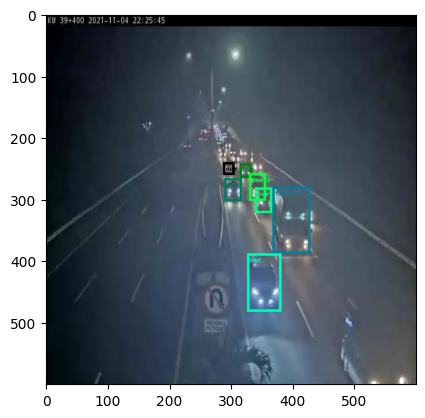

In [ ]:
sample = test_dataset[32]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(img_int,
                               sample[1]['boxes'],
                               [classes[i] for i in sample[1]['labels']],
                               width=4).permute(1, 2, 0)
          )

### Dataset Split

In [ ]:
print("Number of images for training:", len(train_dataset))
print("Number of images for validation:", len(val_dataset))
print("Number of images for testing:", len(test_dataset))

Number of images for training: 2633
Number of images for validation: 963
Number of images for testing: 454


### Making Dataloaders

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=4,
    collate_fn=collate_fn
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16, shuffle=True, num_workers=4,
    collate_fn=collate_fn
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=16, shuffle=True, num_workers=4,
    collate_fn=collate_fn
)

## Model Loading
#### Using FASTERRCNN MOBILENET

In [ ]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:01<00:00, 75.0MB/s]


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
device

device(type='cuda')

### Setting Hyperparameters

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.05,
                            momentum=0.9, nesterov=True, weight_decay=1e-4)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1)

### Defining the training loop

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.to(device)
    model.train()
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        losses_reduced = sum(loss for loss in loss_dict.values())

        loss_value = losses_reduced.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}: lr: {:.6f} loss: {:.6f}, loss_classifier: {:.6f}, loss_box_reg: {:.6f}, loss_rpn_box_reg: {:6f}, loss_objectness: {:.6f}".format(
        epoch, optimizer.param_groups[0]["lr"], np.mean(all_losses),
        all_losses_dict["loss_classifier"].mean(),
        all_losses_dict["loss_box_reg"].mean(),
        all_losses_dict["loss_rpn_box_reg"].mean(),
        all_losses_dict["loss_objectness"].mean(),
    ))

### Evaluation metric, which will be called after each epoch on validation dataset

In [ ]:
map_metric = torchmetrics.detection.mean_ap.MeanAveragePrecision()
def evaluate(model, test_dataloader):
  model.eval()
  with torch.no_grad():
    for images, targets in tqdm(test_loader):
      images = [image.to(device) for image in images]
      targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

      outputs = model(images)
      map_metric.update(outputs, targets)

      final_map = map_metric.compute()
      torch.cuda.empty_cache()

  print(final_map)
  # Reset metric
  map_metric.reset()
  return final_map

## Training

In [ ]:
# let's train it for 50 epochs
num_epochs = 50

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=28)
    lr_scheduler.step()
    evaluate(model, val_loader)

# Save the trained model
save_path = '/content/drive/MyDrive/SEM 1/TML/pytorch-faster-rcnn/saved_models/exp3/'
make_dir(save_path)
torch.save(model.state_dict(), os.path.join(save_path, 'trained_model.pth'))

## Evaluation on Testing Data

##### Define the model architecture (if not defined already)

In [ ]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

# Load the trained weights
save_path = '/content/drive/MyDrive/SEM 1/TML/pytorch-faster-rcnn/saved_models/exp2/'
model.load_state_dict(torch.load(os.path.join(save_path, 'trained_model.pth')))
model.to(device)
# Set the model to evaluation mode
model.eval()
torch.cuda.empty_cache()

### To calculate precision and recall on testing data

In [ ]:
def calculate_iou(boxA, boxB):
    # Calculate intersection coordinates
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Calculate intersection area
    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Calculate boxA and boxB areas
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Calculate Union area
    union_area = float(boxA_area + boxB_area - intersection_area)

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0

    return iou

def calculate_tp_fp_fn(predicted_boxes, predicted_scores, predicted_labels, gt_boxes, gt_labels, threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for gt_idx, gt_box in enumerate(gt_boxes):
        matched = False

        for pred_idx, pred_box in enumerate(predicted_boxes):
            if predicted_labels[pred_idx] == gt_labels[gt_idx]:
                iou = calculate_iou(pred_box, gt_box)
                if iou > threshold:
                    true_positives += 1
                    matched = True
                    break

        if not matched:
            false_negatives += 1

    false_positives = len(predicted_boxes) - true_positives

    # precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    # recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return  true_positives, false_positives, false_negatives

def calculate_prec_rec(model, test_dataset):

  true_positives = 0
  false_positives = 0
  false_negatives = 0

  for i in tqdm(range(len(test_dataset))):
    img, target = test_dataset[i]
    img_int = torch.tensor(img * 255, dtype=torch.uint8)
    with torch.no_grad():
        prediction = model([img.to(device)])
        pred = prediction[0]

    predicted_boxes = pred['boxes'].detach().cpu().numpy()
    predicted_scores = pred['scores'].detach().cpu().numpy()
    predicted_labels = pred['labels'].detach().cpu().numpy()
    gt_boxes = target['boxes'].numpy()
    gt_labels = target['labels'].numpy()

    t1, t2, t3 = calculate_tp_fp_fn(predicted_boxes, predicted_scores, predicted_labels, gt_boxes, gt_labels)
    true_positives += t1
    false_positives += t2
    false_negatives += t3

  precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
  recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

  return precision, recall

prec, rec = calculate_prec_rec(model, test_dataset)

print("Precision:", prec)
print("Recall:", rec)


### Inference on Single image

In [ ]:
img, _ = test_dataset[32]
img_int = torch.tensor(img * 255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

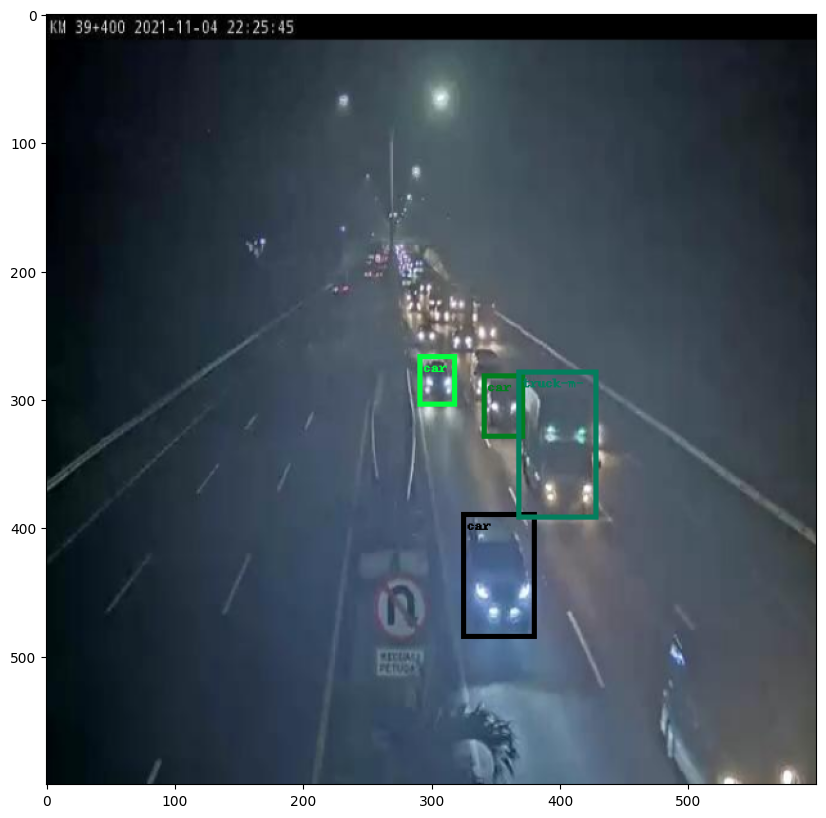

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
                               pred['boxes'][pred['scores'] > 0.8],
                               [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()],
                               width=4).permute(1, 2, 0)
          )